<h1>Format Step by Step for testing<h1>

In [172]:
import ast
import pandas as pd
import re

def remove_endoftext(text):
    """ Remove all EOS token from the generated."""
    # remove all unecessary '\n' 
    new_text = text.strip()
    # remove all endoftext tokens
    return new_text.replace('<|endoftext|>', '')

def extract_first_function_block(text):
    # Using a regex pattern to match function blocks starting with 'def' keyword
    # and ending right before the next 'def' or the end of the text.
    pattern = r"(def [^\n]+:\n(?:\s+[^\n]*\n)*)"
    
    matches = re.findall(pattern, text)

    return matches[0] if matches else None

    
def format_testing_stepBystep(data):
    """ Format for testing."""
    code_to_test = []

    for k in range(len(data)):
        # will take the last one 
        text = data.iloc[k]['gen_code']
        processed_text = remove_endoftext(text)
        code_to_test.append(extract_first_function_block(processed_text))
    
    data['code_test'] = code_to_test

    return data


#KW
KeyWordScope_fullContext = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/fullContext.csv')
KeyWordScope_fullContext = format_testing_stepBystep(KeyWordScope_fullContext)
KeyWordScope_fullContext.to_csv('data/MTBP/step_by_step/KeyWordandScope/fullContext.csv')
# KeyWordScope
KeyWordScope_fullContext_no = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/fullContext_no#.csv')
KeyWordScope_fullContext_no = format_testing_stepBystep(KeyWordScope_fullContext_no)
KeyWordScope_fullContext_no.to_csv('data/MTBP/step_by_step/KeyWordandScope/fullContext_no#.csv')

KeyWordScope_actualContext = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/actualContext.csv')
KeyWordScope_actualContext = format_testing_stepBystep(KeyWordScope_actualContext)
KeyWordScope_actualContext.to_csv('data/MTBP/step_by_step/KeyWordandScope/actualContext.csv')

KeyWordScope_actualContext_no = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/actualContext_no#.csv')
KeyWordScope_actualContext_no = format_testing_stepBystep(KeyWordScope_actualContext_no)
KeyWordScope_actualContext_no.to_csv('data/MTBP/step_by_step/KeyWordandScope/actualContext_no#.csv')

# Kw Replace
KeyWordScope_fullContext_Rp = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/fullContext.csv')
KeyWordScope_fullContext_Rp = format_testing_stepBystep(KeyWordScope_fullContext_Rp)
KeyWordScope_fullContext_Rp.to_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/fullContext.csv')

KeyWordScope_fullContext_no_Rp = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/fullContext_no#.csv')
KeyWordScope_fullContext_no_Rp = format_testing_stepBystep(KeyWordScope_fullContext_no_Rp)
KeyWordScope_fullContext_no_Rp.to_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/fullContext_no#.csv')

KeyWordScope_actualContext_Rp = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/actualContext.csv')
KeyWordScope_actualContext_Rp = format_testing_stepBystep(KeyWordScope_actualContext_Rp)
KeyWordScope_actualContext_Rp.to_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/actualContext.csv')

KeyWordScope_actualContext_no_Rp = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/actualContext_no#.csv')
KeyWordScope_actualContext_no_Rp = format_testing_stepBystep(KeyWordScope_actualContext_no_Rp)
KeyWordScope_actualContext_no_Rp.to_csv('data/MTBP/step_by_step/KeyWordandScope/ReplaceFinalPrint/actualContext_no#.csv')

# Large
Large_fullContext = pd.read_csv('data/MTBP/step_by_step/Large/fullContextLarge.csv')
Large_fullContext = format_testing_stepBystep(Large_fullContext)
Large_fullContext.to_csv('data/MTBP/step_by_step/Large/fullContextLarge.csv')

Large_fullContext_no = pd.read_csv('data/MTBP/step_by_step/Large/fullContext_no#.csv')
Large_fullContext_no = format_testing_stepBystep(Large_fullContext_no)
Large_fullContext_no.to_csv('data/MTBP/step_by_step/Large/fullContext_no#.csv')

Large_actualContext = pd.read_csv('data/MTBP/step_by_step/Large/actualContext.csv')
Large_actualContext = format_testing_stepBystep(Large_actualContext)
Large_actualContext.to_csv('data/MTBP/step_by_step/Large/actualContext.csv')

Large_actualContext_no = pd.read_csv('data/MTBP/step_by_step/Large/actualContext_no#.csv')
Large_actualContext_no = format_testing_stepBystep(Large_actualContext_no)
Large_actualContext_no.to_csv('data/MTBP/step_by_step/Large/actualContext_no#.csv')

# OneLine
OneLine_fullContext = pd.read_csv('data/MTBP/step_by_step/OneLine/fullContext.csv')
OneLine_fullContext = format_testing_stepBystep(OneLine_fullContext)
OneLine_fullContext.to_csv('data/MTBP/step_by_step/OneLine/fullContext.csv')

OneLine_actualContext = pd.read_csv('data/MTBP/step_by_step/OneLine/actualContext.csv')
OneLine_actualContext = format_testing_stepBystep(OneLine_actualContext)
OneLine_actualContext.to_csv('data/MTBP/step_by_step/OneLine/actualContext.csv')

#Structural
Structural_fullContext = pd.read_csv('data/MTBP/step_by_step/Structural/fullContext.csv')
Structural_fullContext = format_testing_stepBystep(Structural_fullContext)
Structural_fullContext.to_csv('data/MTBP/step_by_step/Structural/fullContext.csv')

Structural_fullContext_no = pd.read_csv('data/MTBP/step_by_step/Structural/fullContext_no#.csv')
Structural_fullContext_no = format_testing_stepBystep(Structural_fullContext_no)
Structural_fullContext_no.to_csv('data/MTBP/step_by_step/Structural/fullContext_no#.csv')

Structural_actualContext_no = pd.read_csv('data/MTBP/step_by_step/Structural/actualContext_Str_no#.csv')
Structural_actualContext_no = format_testing_stepBystep(Structural_actualContext_no)
Structural_actualContext_no.to_csv('data/MTBP/step_by_step/Structural/actualContext_Str_no#.csv')

Structural_actualContext = pd.read_csv('data/MTBP/step_by_step/Structural/actualContext_Str.csv')
Structural_actualContext = format_testing_stepBystep(Structural_actualContext)
Structural_actualContext.to_csv('data/MTBP/step_by_step/Structural/actualContext_Str.csv')

# noContext : extra work to do
# signatureOnly
KeyWordScope_signatureOnly = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/signatureOnly.csv')
KeyWordScope_signatureOnly_no = pd.read_csv('data/MTBP/step_by_step/KeyWordandScope/signatureOnly_no#.csv')
Large_signatureOnly = pd.read_csv('data/MTBP/step_by_step/Large/signatureOnly.csv')
Large_signatureOnly_no = pd.read_csv('data/MTBP/step_by_step/Large/signatureOnly_no#.csv')
OneLine_signatureOnly = pd.read_csv('data/MTBP/step_by_step/OneLine/signatureOnly.csv')

Structural_actualContext, Structural_actualContext_no, Large_actualContext, Large_fullContext_no, Large_fullContext
KeyWordScope_actualContext_no, KeyWordScope_actualContext,KeyWordScope_fullContext_Rp, KeyWordScope_fullContext_no_Rp,
KeyWordScope_actualContext_Rp, KeyWordScope_actualContext_no_Rp

In [173]:
Structural_actualContext.iloc[0]

Unnamed: 0                                                        0
prompts           ['Assign the string "{A}" to a variable named ...
inputs            [{'A': 'abcde'}, {'A': 'abcdecadeCADE'}, {'A':...
outputs           [['a', 'b', 'c', 'd', 'e'], ['a', 'b', 'c', 'd...
max_gen_length                                                128.0
category                                                     string
name                                                Sandwich string
description        Append a string in the middle of another string.
id                                                                1
signature                                   def sandwich_string(A):
test_list         ["assert sandwich_string('abcde') == ['a', 'b'...
gen_code          def sandwich_string(A):\n\tmy_string = "{A}"\n...
code_test         def sandwich_string(A):\n\tmy_string = "{A}"\n...
Name: 0, dtype: object

<h1>Stopping Criteria</h1>

In [ ]:
import re

def remove_return_and_print_lines(text):
    lines = text.split('\n')
    cleaned_lines = [line for line in lines if not re.match(r'^\s*(return|print)', line)]
    return '\n'.join(cleaned_lines)

def remove_print_lines(text):
    lines = text.split('\n')
    cleaned_lines = [line for line in lines if not re.match(r'^\s*print', line)]
    return '\n'.join(cleaned_lines)

def remove_endoftext(text):
    """ Remove all EOS token from the generated."""
    # remove all unecessary '\n' 
    new_text = text.strip()
    # remove all endoftext tokens
    return new_text.replace('<|endoftext|>', '')

def stopping_generation(model, decoded_output, index, length_prompt):
    """ 
    This function stops the generation with the following stopping criteria:
        - leaving the scope of the function (for function only e.g. does not work for prompt out of scope function)
        - finds a stopping keyword : 'print', 'return' if not the last prompt
        - finds a <|endoftext|>
    """

    # First, removing everything outside of the function scope
    processed_output = model.extract_function_block(decoded_output)

    # Second, remove if a stopping keyword if found !         
    # if this is not the last one, we remove the return
    if index != (length_prompt - 1):
        processed_output = remove_return_and_print_lines(processed_output)
    else:
        processed_output = remove_print_lines(processed_output)

    # Third remove all <|endoftextf|>
    processed_output = remove_endoftext(processed_output)

    return processed_output

<h1>Length Penalty Algorithm</h1>

Create dataset with alpha-values corresponding:
<p>reference is the length of the context less: </p>
<p></p>
        set the alpha values for all generation step in each problem
                max value equal two, smallest value is zero.five 
                keep only instruction steps codes lenghts 


In [5]:
from get_data import * 
dataset = custom_dataset(prompt_vs_context)

c:\Users\mariu\anaconda3\envs\comp0197-pt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
import ast

def generation_functions_with_len_penalty(data, model, early_stopping = None):
    """ 
        Generation of the context functions with a evoluting length penalty.
    """

    # Codes for every problem
    codes_with_context = []

    for j in range(len(data)):
        if early_stopping is not None and j > early_stopping:
            break
        
        # Code for every prompt
        code_with_context = []

        # start with the signature for the incoming problem
        code = data.iloc[j]['signature']

        # initiate the list of prompt to generate
        prompts = ast.literal_eval(data.iloc[j]['prompts'])
        
        # inititate the alphas for the generation penalty
        alphas = data.iloc[j]['alphas']
        
        for i, prompt in enumerate(prompts):
            
            # input text
            function = code + '\n\t#' + prompt

            # tokenization
            ids_function = model.tokenizer.encode(function, return_tensors='pt')

            # generation 
            output_function = model.forward(ids_function)

            # processing 
            processed_output_ids = generation_post_processing(model, output_function, i, len(prompts))
            
            # length penalty algorithm
            # select within the list of sequence generated the best one according of their log-likelihood
            best_output = pick_best_length(model, processed_output_ids, alphas[i])

            # decoding
            text_function = model.decode_output(best_output)

            # post processing
            text_function = model.post_generation_processing(text_function)

            # enlarge the context
            code = text_function

            # add to the list
            code_with_context.append(text_function)

        codes_with_context.append(code_with_context)

    return codes_with_context

In [ ]:
def generation_functions_with_len_penalty(data, model, type_of_lenght = 'token', early_stopping = None):
    """
        Generation of the context functions with a evoluting length penalty.
    """

    # Codes for every problem
    codes_with_context = []
    model.to('cuda')
    for j in range(len(data)):
        if early_stopping is not None and j > early_stopping:
            break

        # Code for every prompt
        code_with_context = []

        # start with the signature for the incoming problem
        code = data.iloc[j]['signature']
        # initiate the list of prompt to generate
        prompts = ast.literal_eval(data.iloc[j]['prompts'])
        # inititate the alphas for the generation penalty
        alphas = data.iloc[j]['alphas']

        for i, prompt in enumerate(prompts):

            # input text
            function = code + '\n\t#' + prompt
            # tokenization
            ids_function = model.tokenizer.encode(function, return_tensors='pt').to('cuda')

            # generation
            output_function = model.forward(ids_function).to('cuda')

            # post processing
            # '\t' count --> set to x whenever it changes leave... --> Y decoded outputs --> log likelihood
            processed_output_ids, output_text_processed = generation_post_processing(model, output_function, i, len(prompts))
            
            # length penalty algorithm
            # select within the list of sequence generated the best one according of their log-likelihood
            best_output = pick_best_length(model, processed_output_ids, alphas[i], type_of_lenght, output_text_processed, i)

            # decoding
            text_function = model.decode_output(best_output)

            # post processing
            # text_function = model.post_generation_processing(text_function)

            # enlarge the context
            code = text_function

            # add to the list
            code_with_context.append(text_function)

        codes_with_context.append(code_with_context)

    return codes_with_context

In [22]:
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

class MySantaCoder(nn.Module):
    def __init__(self, generation_method, list_of_bad_words = ['#', '"""'], max_tokens = 128, num_beam = 1, num_sol = 1):
        super(MySantaCoder, self).__init__()
        self.checkpoint = "bigcode/santacoder"
        # self.checkpoint = model_path_to_hub
        self.model = AutoModelForCausalLM.from_pretrained(self.checkpoint, trust_remote_code=True)
        self.tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
        self.max_new_tokens = max_tokens
        self.bad_words = self.get_input_ids_as_list(list_of_bad_words)

        if generation_method == 'GrdS':

            self.generation_config = GenerationConfig(
                bad_words_ids = self.bad_words,
                num_beams = num_beam,
                num_return_sequences = num_sol,
                max_new_tokens = self.max_new_tokens,
                eos_token_id=self.model.generation_config.eos_token_id,
                bos_token_id=self.model.generation_config.bos_token_id
                )
        elif generation_method == 'SmplM' : 
     
            self.generation_config = GenerationConfig( 
                bad_words_ids = self.bad_words,  
                do_sample = True,  
                num_beams = num_beam,
                num_return_sequences = num_sol,
                top_p = 0.8,
                temperature = 0.95,
                max_new_tokens = self.max_new_tokens,
                eos_token_id=self.model.generation_config.eos_token_id,
                bos_token_id=self.model.generation_config.bos_token_id
                )
    
    def get_input_ids_as_list(self, list_of_bad_words):
        """ Tokenize the list of bad words - meaning the word that should not be generated"""
        token_list = []
        for element in list_of_bad_words:
            token_list.append(self.tokenizer.encode(element))
        return token_list
    
    def forward(self, input_ids):
        # input_ids = input_ids.unsqueeze(0)
        outputs = self.model.generate(input_ids, self.generation_config)
        return outputs

    def decode_output(self, encoded_output):
        output = self.tokenizer.decode(encoded_output)
        return output

    def post_generation_processing(self, code):
        """ Post processing that keeps only the fist def/class block and remove extra lines skipped."""

        # split it into list of blocks
        list_blocks = re.split('def |class |assert |print ', code)

        if 'init' in list_blocks[1]:
            fill_word = '\nclass '
        else:
            fill_word = '\ndef '

        # keep only the first block
        result = list_blocks[0] + fill_word + list_blocks[1]

        # remove all trailing newlines
        while result.endswith('\n'):
            result = result[:-1]

        # remove all leading newlines
        while result.startswith('\n'):
            result = result[1:]

        return result

    def extract_function_block(self, text):
        """ Extraction of the function by counting the number of indentation"""
        lines = text.split('\n')
        result = []

        indent_level = None
        for line in lines:
            if line.strip() == '':  # Ignore empty lines
                continue

            current_indent = len(line) - len(line.lstrip())

            if indent_level is None:  # For the first 'def' line
                indent_level = current_indent
                result.append(line)
                continue

            if current_indent > indent_level:  # Inside the function's scope
                result.append(line)
            else:  # Outside the function's scope or another function
                break

        return '\n'.join(result)

c:\Users\mariu\anaconda3\envs\comp0197-pt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Exploration of the dataset

In [14]:
import ast

def remove_endoftext(text):
    """ Remove all EOS token from the generated."""
    # remove all unecessary '\n' 
    new_text = text.strip()
    # remove all endoftext tokens
    return new_text.replace('<|endoftext|>', '')

def format_testing_lenght_penalty(data):
    """ Format testing for the Ubuntu."""
    code_to_test = []

    for k in range(len(data)):
        # will take the last one 
        text = ast.literal_eval(data.iloc[k]['lenght_penalty_generation'])[-1]
        processed_text = remove_endoftext(text)
        code_to_test.append(processed_text)
    
    data['code_test'] = code_to_test

    return data

data_len_w = format_testing_lenght_penalty(data_len_words)
data_len_t = format_testing_lenght_penalty(data_len_token)
data_len_l = format_testing_lenght_penalty(data_len_lines)

data_len_w.to_csv('data/MTBP/Prompt_vs_context/Testing/words_length_penalty_noreturns.csv')
data_len_t.to_csv('data/MTBP/Prompt_vs_context/Testing/token_length_penalty_noreturns.csv')
data_len_l.to_csv('data/MTBP/Prompt_vs_context/Testing/lines_lenght_penalty_noreturns.csv')

In [ ]:
print(data_len_w.iloc[8]['code_test'])

In [49]:
from get_data import *

mtbp = read_json_line_format('data/MTBP/mtpb.jsonl')
mtbp_converted = read_json_line_format('data/MTBP/converted_mtpb.jsonl')

In [1]:
def structural_cut_off(text, prompt):
    lines = text.splitlines()
    prompt_idx = 0

    def check_keywords_after_prompt(lines, prompt):

        # Nested function to get the length of code snippets based on indentation
        def length_of_code_snippets(indentation, lines_after_prompt):
            count = 0
            for line in lines_after_prompt:
                current_indentation = len(line) - len(line.lstrip('\t'))
                if current_indentation >= indentation:
                    count += 1
                else:
                    break
            return count

        # Find the index of the prompt
        prompt_idx = next((idx for idx, line in enumerate(lines) if line.strip() == prompt), None)

        if prompt_idx is None or prompt_idx == len(lines) - 1:  # If prompt is not found or it's the last line
            return False

        first_line_after_prompt = lines[prompt_idx + 1]
        stripped_line = first_line_after_prompt.lstrip()  # Strip leading whitespace (for keywords check)
        indentation = len(first_line_after_prompt) - len(stripped_line)  # Calculate number of leading tabs

        keywords = ('if', 'for', 'while', 'def', 'class')

        # If the keyword is found in the first line after the prompt
        if stripped_line.split()[0] in keywords:
            code_length = length_of_code_snippets(indentation, lines[prompt_idx + 1:])
            return code_length,prompt_idx
        else:
            return False,prompt_idx

    count,prompt_idx = check_keywords_after_prompt(lines, prompt)

    if count is not False:
        return '\n'.join(lines[:prompt_idx + count + 1])
    else:
        return '\n'.join(lines[:prompt_idx + 1])


<h1> MTPB <h1>

In [127]:
import ast


def create_plot_Alpha(mtpb_data):

    alphas = []

    for i in range(len(mtpb_data)):
        alphas.append(ast.literal_eval(mtpb_data.iloc[i]['alphas']))
    
    flat_alpha = [item for sublist in alphas for item in sublist]

    return flat_alpha

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(values, title="Value Distribution"):
    """
    Plot the distribution of values in a style suited for top-tier ML conferences.

    Args:
    - values (list): A list of numerical values.
    - title (str): The title for the plot.

    Returns:
    - None
    """
    # Set the style for seaborn
    sns.set_style("whitegrid")
    
    # Set the context to "talk" for larger fonts and lines
    sns.set_context("talk")

    # Create the plot
    plt.figure(figsize=(12, 7))
    sns.histplot(values, kde=True, bins=30, color='dodgerblue', linewidth=2)

    # Set the title, labels, and show the plot
    plt.title(title, fontsize=18)
    plt.xlabel("Alpha Value", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

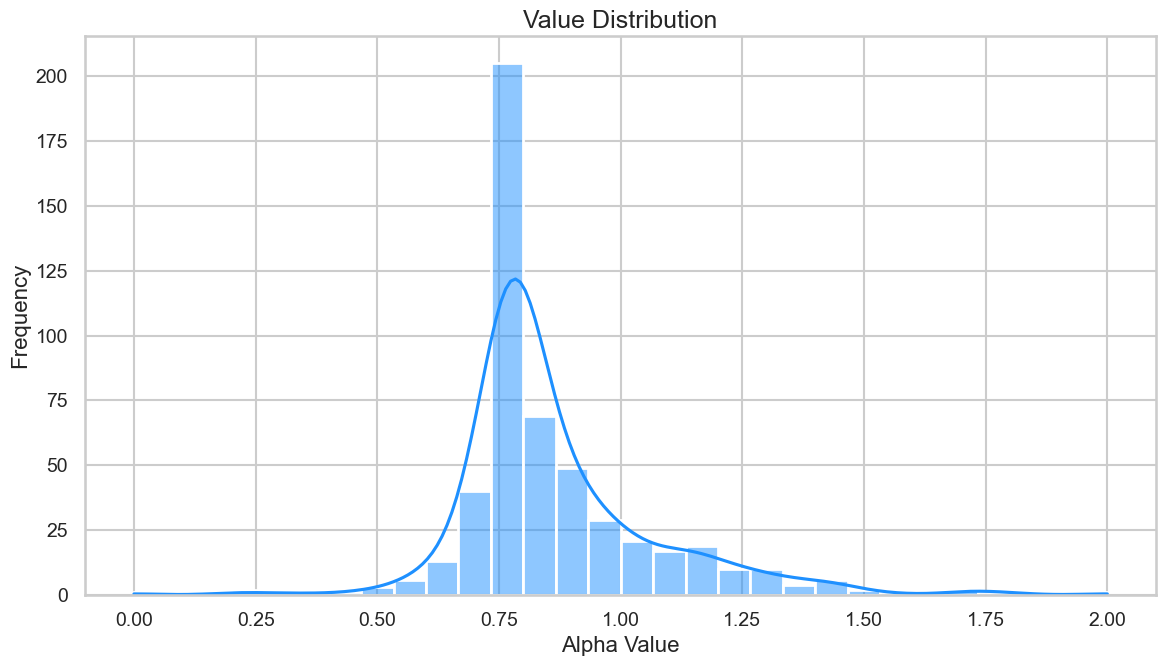

In [129]:
alpha_diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/Normaly/MTBP_Alpha_Diff_LenToken.csv')
plot_distribution(create_plot_Alpha(alpha_diff))

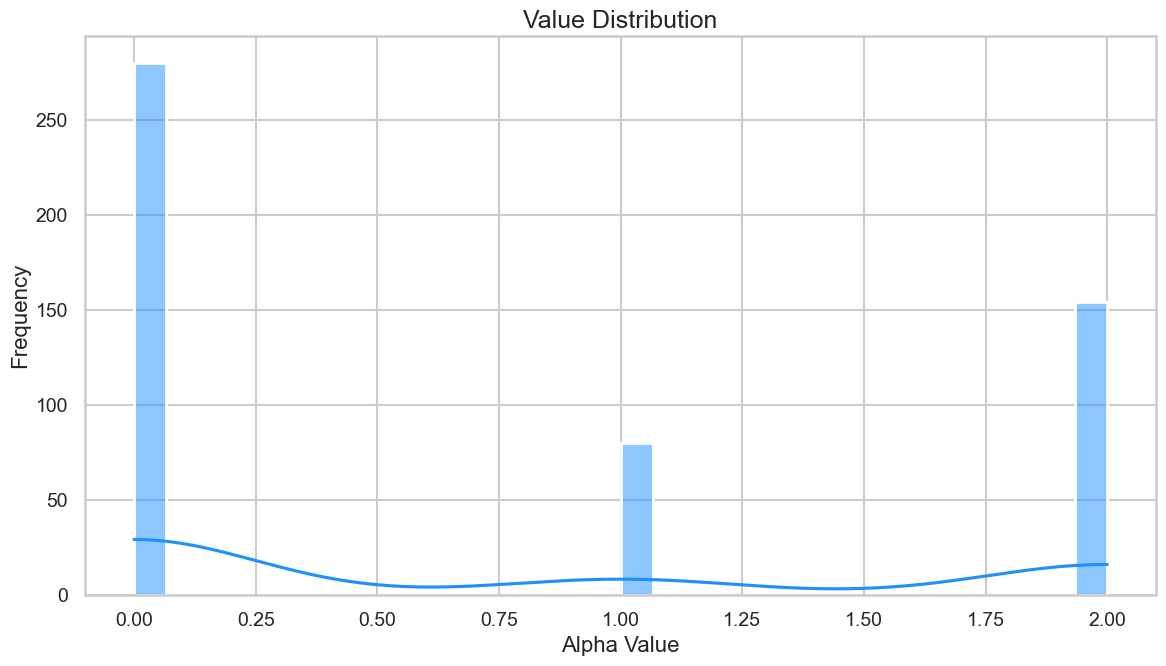

In [27]:
alpha_aor = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/02/MTBP_Alpha_AOR_LenToken.csv')
plot_distribution(create_plot_Alpha(alpha_aor))

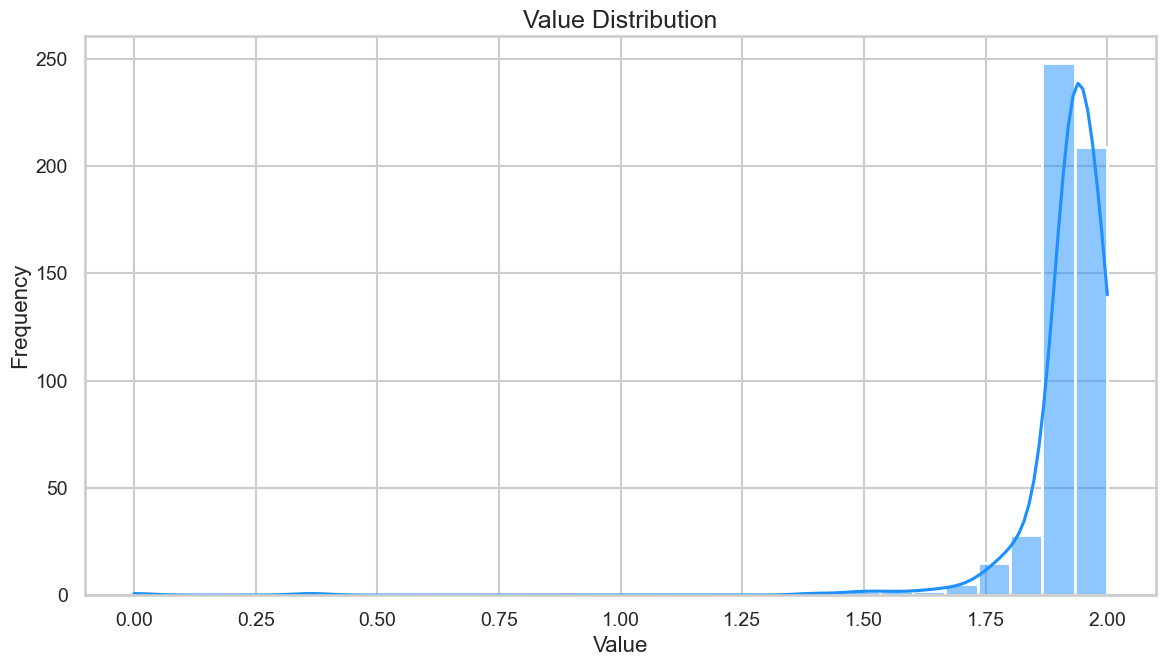

In [23]:
alpha_ratio = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Ratio/mtbp_AlphaRatio.csv')
plot_distribution(create_plot_Alpha(alpha_ratio))

In [ ]:
def alphas_columns(a,b,lengths_prompt, lengths_context):
    # create normalized diff
    diff_length = []

    for i in range(len(lengths_prompt)):
        lenght_step = []
        for j in range(len(lengths_prompt[i])):

            nominateur = lengths_prompt[i][j]
            denominateur = lengths_context[i][j]

            if nominateur == 0 and denominateur!= 0:
                lenght_step.append(1)
            elif denominateur == 0 and nominateur!=0:
                lenght_step.append(1)
            elif denominateur == 0 and nominateur == 0:
                lenght_step.append(1)
            else:
                lenght_step.append(nominateur/denominateur)

        diff_length.append(lenght_step)
    
    normalized_alphas = reverse_normalize(diff_length, a, b)

    return normalized_alphas

In [ ]:
def alpha_ratio(lengths_prompt, lengths_context):
  """ Calculate the difference for each generation"""
    diff_lenghts = []

    lenght_problem = len(lengths_prompt)

    for index_prob in range(lenght_problem):
        ratio_length_generation = []

    for index_subPro in range(len(lengths_prompt[index_prob])):
        if lengths_prompt[index_prob][index_subPro] == 0:
            diff_length_generation()
        elif lengths_context[index_prob][index_subPro] == 0:
        
        else:
            diff_length_generation.append(lengths_prompt[index_prob][index_subPro] - lengths_context[index_prob][index_subPro])

        diff_lenghts.append(diff_length_generation)

  return diff_lenghts

<h1>Prompt vs Context Length exploration<h1>

In [27]:

from output_analysis_utils import *
import pandas as pd

data = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/noContext_fullContext.csv')

r = run_general_analysis(data)

In [ ]:
statistic, p_value = run_hypothesis_testing(data)

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_and_compare_distribution(list1, list2):
    """Compare the two lists and plot the proportion of instances where elements from
    list1 are greater, lesser or equal to those from list2."""

    # Flatten the lists and ensure both arrays have the same length
    flat_list1 = np.array([num for sublist in list1 for num in sublist])
    flat_list2 = np.array([num for sublist in list2 for num in sublist])

    min_length = min(len(flat_list1), len(flat_list2))
    flat_list1 = flat_list1[:min_length]
    flat_list2 = flat_list2[:min_length]

    # Calculate is_greater using numpy operations
    is_greater = np.where(flat_list1 > flat_list2, -1, np.where(flat_list1 < flat_list2, 1, 0))

    # Convert to pandas DataFrame
    df = pd.DataFrame({'Comparison': is_greater})

    # Style settings
    sns.set_style("whitegrid")
    sns.set_context("talk")

    # Plot the distribution of is_greater values
    plt.figure(figsize=(12, 7), dpi=200)
    ax = sns.countplot(data=df, x='Comparison', palette="Blues", order=[-1, 0, 1], saturation=0.7)

    plt.title('Comparison of Length noContext vs fullContext', fontsize=18, fontweight='bold', pad=25)
    plt.ylabel('Count', fontsize=16, fontweight='bold')
    plt.xticks([])  # Hide x-ticks

    # Add labels inside bars
    labels = ['len(noC) > len(fullC)', 'len(noC) = len(fullC)', 'len(noC) < len(fullC)']
    for p, label in zip(ax.patches, labels):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height / 2, label, 
                ha="center", va='center', fontsize=14, fontweight='bold', color='black')

    # Ensure layout is tight so no element is cut off
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [7]:
generated_code_prompt, generated_code_context = process_generated_codes(data)
lengths_prompt, lengths_context = calculate_lengths(generated_code_prompt, generated_code_context)

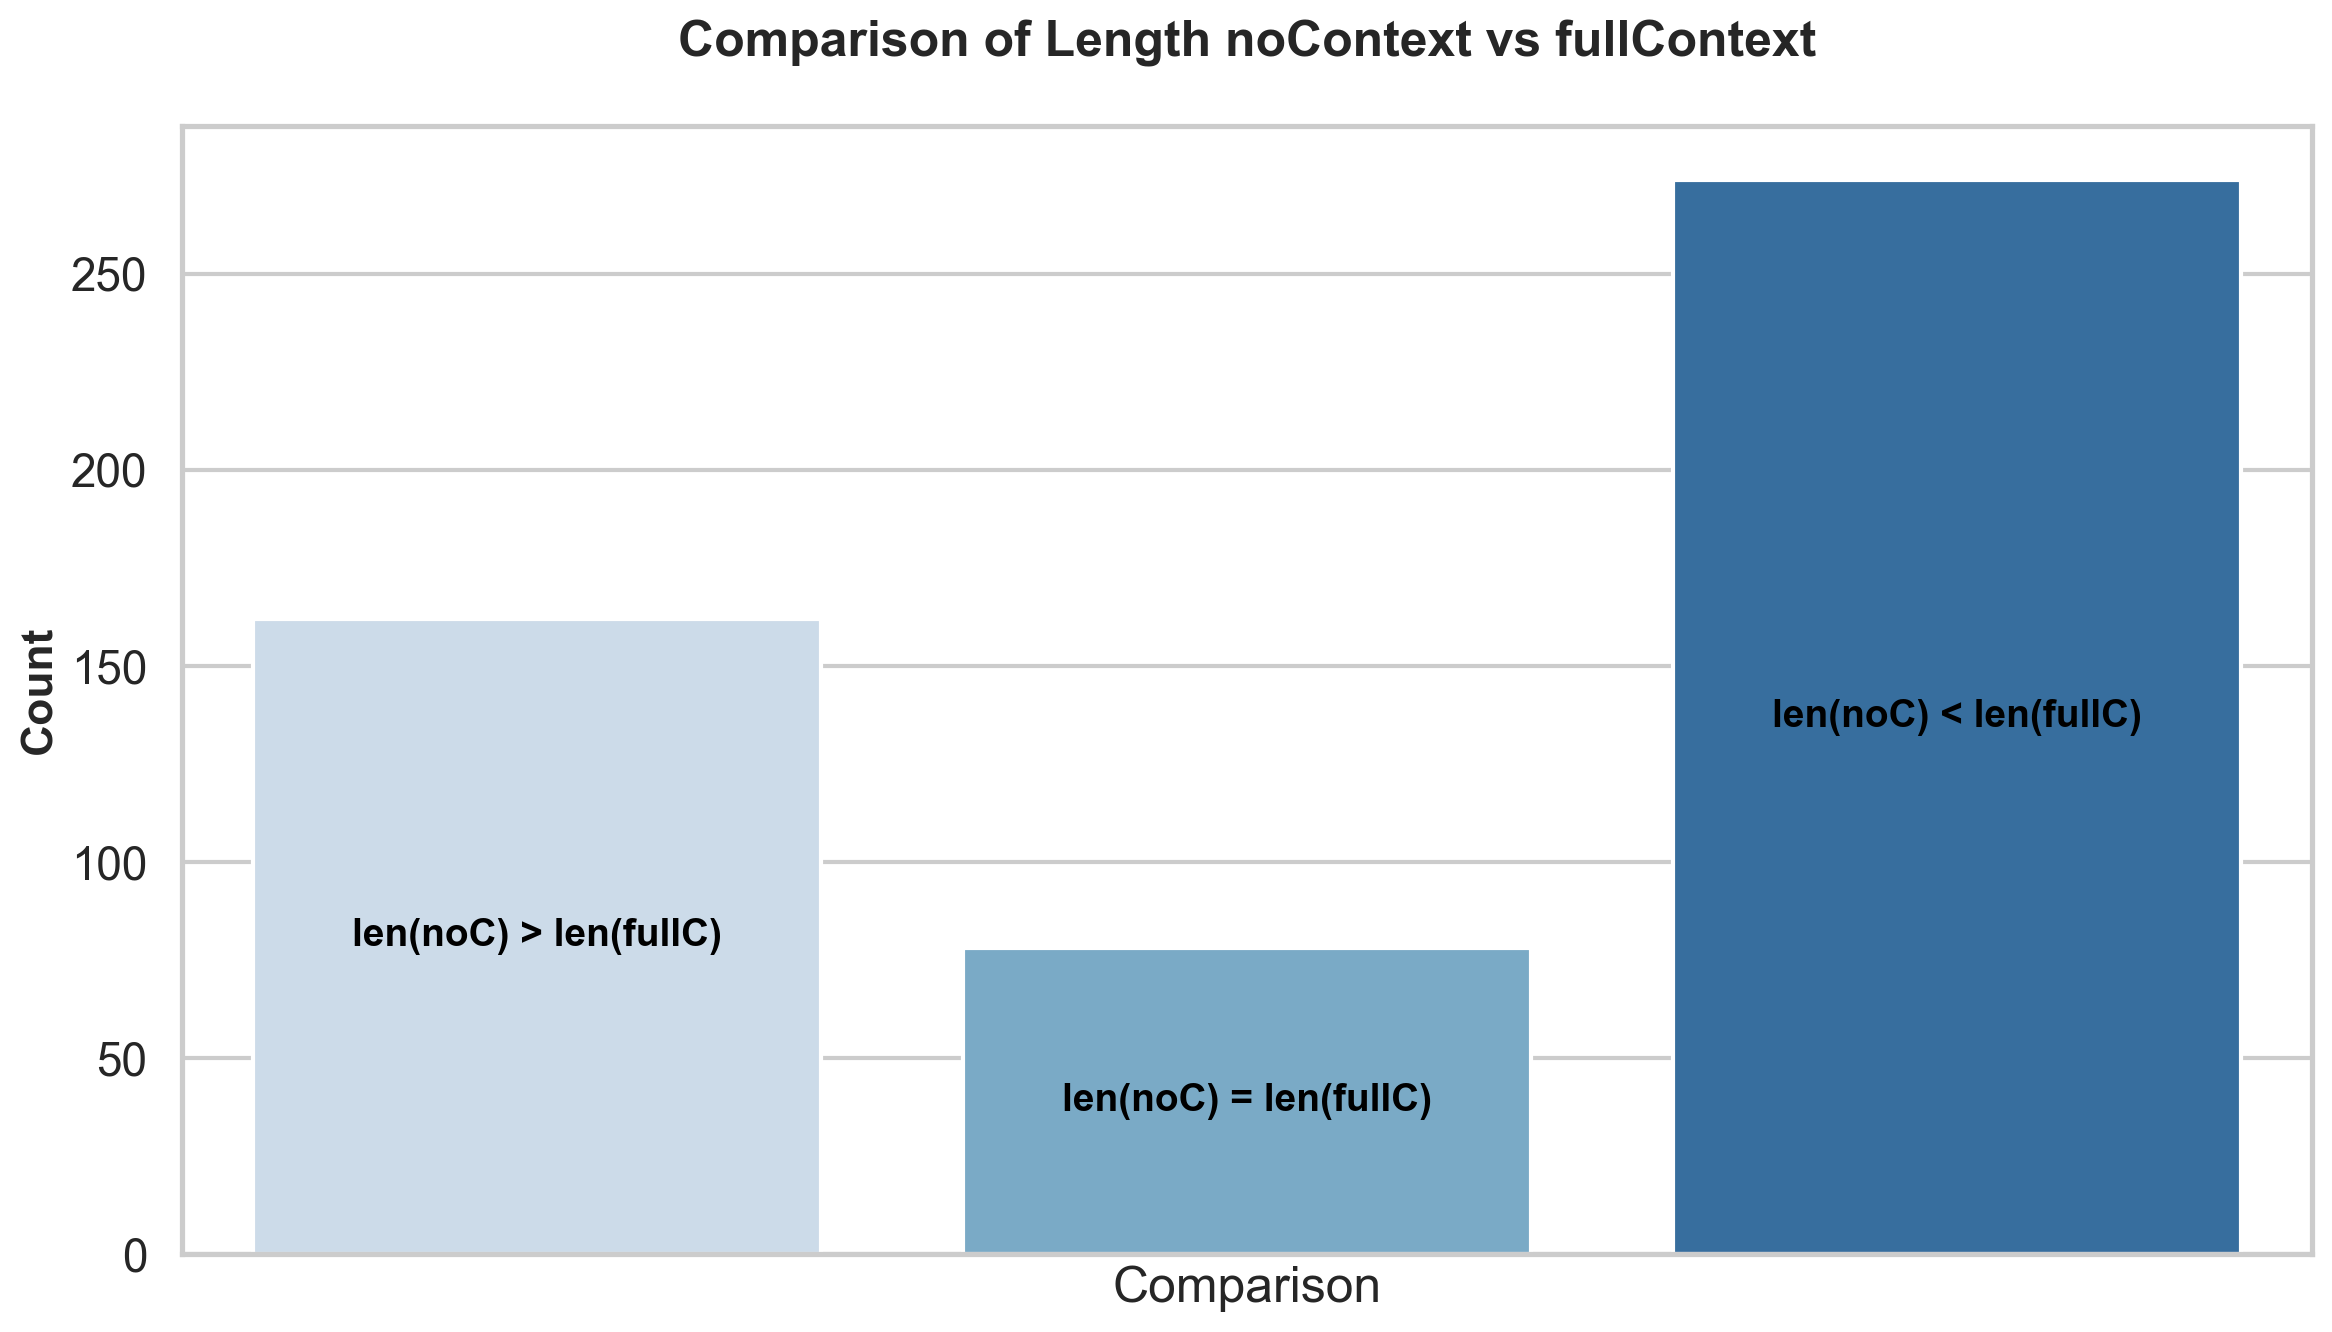

In [26]:
plot_and_compare_distribution(lengths_prompt, lengths_context)

In [73]:
flat_length_noContext = [sum(sublist) for sublist in lengths_prompt]
flat_length_fullContext = [sum(sublist) for sublist in lengths_context]

In [74]:
np.mean(flat_length_noContext)

168.82608695652175

In [75]:
np.mean(flat_length_fullContext)

349.37391304347824

In [82]:
def plot_3x3_histogram(Lines_AoN, Word_AoN, Token_AoN, Lines_Diff, Word_Diff, Token_Diff):
    
    # Compute the means for both AoN and Diff categories
    means_AoN = {
        "Lines_AoN": np.mean(Lines_AoN),
        "Word_AoN": np.mean(Word_AoN),
        "Token_AoN": np.mean(Token_AoN),
    }
    
    means_Diff = {
        "Lines_Diff": np.mean(Lines_Diff),
        "Word_Diff": np.mean(Word_Diff),
        "Token_Diff": np.mean(Token_Diff)
    }

    # Extract names to ensure ordering consistency
    names_AoN = list(means_AoN.keys())
    names_Diff = list(means_Diff.keys())
    
    # Adjust the style to something more muted and professional
    plt.style.use('ggplot')
    
    # Create the 3x3 matrix of histograms
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
                # Plot AoN means on the left (blue-ish bars)
            axes[i, j].bar(0, height=means_AoN[names_AoN[i]], color='#1f77b4', alpha=0.8)
                # Plot Diff means on the right (red-ish bars)
            axes[i, j].bar(1, height=means_Diff[names_Diff[j]], color='#d62728', alpha=0.8)
                
            axes[i, j].set_xlim(-0.5, 2)
            axes[i, j].set_ylim(0, max(max(means_AoN.values()), (max(means_Diff.values())) * 1.1))
            axes[i, j].set_xticks([0, 1])
            axes[i, j].set_xticklabels([names_AoN[i], names_Diff[j]], rotation=45, fontsize=10)
            axes[i, j].set_title(f"{names_AoN[i]} vs {names_Diff[j]}", fontsize=12)
            axes[i, j].grid(axis='y')


    plt.tight_layout()
    plt.show()

In [85]:
import pandas as pd
import ast

Lines_AoN = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/MTBP_Alpha_AOR_lenLine.csv')

def remove_lines_containing_prompts(text, prompts):
    lines = text.split("\n")  # Splitting the text into lines
    
    # Filtering out lines that contain any of the given prompts
    filtered_lines = [line for line in lines if not any(prompt in line for prompt in prompts)]
    
    return "\n".join(filtered_lines[1:])

def length_for_filtered_generated_code(data):

    listOfLength = []

    for i in range(len(data)):

        prompt = ast.literal_eval(data.iloc[i]['prompts'])
        generated_code = data.iloc[i]['code_test']

        filtered_generated_code = remove_lines_containing_prompts(generated_code, prompt)

        listOfLength.append(len(filtered_generated_code))
    
    return listOfLength

In [ ]:
Lines_AoN = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/MTBP_Alpha_AOR_lenLine.csv')
Word_AoN = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/MTBP_Alpha_AOR_lenWord.csv')
Token_AoN = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/MTBP_Alpha_AOR_lenToken.csv')
Token_Diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/Normaly/MTBP_Alpha_Diff_LenToken.csv')
Word_Diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/Normaly/MTBP_Alpha_Diff_LenWord.csv')
Token_Lines = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/MTBP_Alpha_Diff_lenLine.csv')
# Word_AoN  = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/5-3/MTBP_Alpha_AOR_EightMinSix_LenToken.csv')

In [178]:
Token_Diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/Normaly/MTBP_Alpha_Diff_LenToken.csv')
Word_Diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/Normaly/MTBP_Alpha_Diff_LenWord.csv')
Token_Lines = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/MTBP_Alpha_Diff_lenLine.csv')

In [187]:
ZeroTwo_AOR_Line = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/02/MTBP_Alpha_AOR_LenLine.csv')
ZeroTwo_AOR_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/02/MTBP_Alpha_AOR_LenToken.csv')
ZeroTwo_AOR_Word = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/02/MTBP_Alpha_AOR_LenWord.csv')
MinThreeFive_AOR_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/5-3/MTBP_Alpha_AOR_FiveMinThree_LenToken.csv')
EightMinSix_AOR_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/8-6/MTBP_Alpha_AOR_MinSixEight_lenToken.csv')
MinTwoFour_Lines_Diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/4-2/MTBP_Alpha_Diff_MinTwoFour_lenLine.csv')
MinTwoFour_Token_Diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/4-2/MTBP_Alpha_Diff_MinTwoFour_lenToken.csv')
MinTwoFour_Word_Diff = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/4-2/MTBP_Alpha_Diff_MinTwoFour_lenWord.csv')
EightMinSix_Diff_Token  = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/8-6/MTBP_Alpha_Diff_MinSixEightr_lenToken.csv')

In [109]:
def format_testing_lenght_penalty(data):
    """ Format testing for the Ubuntu."""
    code_to_test = []

    for k in range(len(data)):
        # will take the last one 
        text = ast.literal_eval(data.iloc[k]['lenght_penalty_generation'])[-1]
        processed_text = remove_endoftext(text)
        code_to_test.append(processed_text)
    
    data['code_test'] = code_to_test

    return data

In [188]:
# [0,2]
ZeroTwo_AOR_Line = format_testing_lenght_penalty(ZeroTwo_AOR_Line)
ZeroTwo_AOR_Token = format_testing_lenght_penalty(ZeroTwo_AOR_Token)
ZeroTwo_AOR_Word = format_testing_lenght_penalty(ZeroTwo_AOR_Word)

# [-2, 4]
MinThreeFive_AOR_Token = format_testing_lenght_penalty(MinThreeFive_AOR_Token)
MinTwoFour_Lines_Diff = format_testing_lenght_penalty(MinTwoFour_Lines_Diff)
MinTwoFour_Token_Diff = format_testing_lenght_penalty(MinTwoFour_Token_Diff)
MinTwoFour_Word_Diff = format_testing_lenght_penalty(MinTwoFour_Word_Diff)

# [-6, 8]
EightMinSix_AOR_Token = format_testing_lenght_penalty(EightMinSix_AOR_Token)
EightMinSix_Diff_Token = format_testing_lenght_penalty(EightMinSix_Diff_Token)


In [ ]:
# Lines_AoN, Word_AoN, Token_AoN, Lines_Diff, Word_Diff, Token_Diff
len_Lines_AoN = length_for_filtered_generated_code(Lines_AoN)
len_Word_AoN = length_for_filtered_generated_code(Word_AoN)
len_Token_AoN = length_for_filtered_generated_code(Token_AoN)
len_Lines_Diff = length_for_filtered_generated_code(Lines_Diff)
len_Word_Diff = length_for_filtered_generated_code(Word_Diff)
len_Token_Diff = length_for_filtered_generated_code(Token_Diff)
Token_AOR_new = length_for_filtered_generated_code(Token_AOR_new)

In [189]:
# [0,2]
len_ZeroTwo_AOR_Line = length_for_filtered_generated_code(ZeroTwo_AOR_Line)
len_ZeroTwo_AOR_Token = length_for_filtered_generated_code(ZeroTwo_AOR_Token)
len_ZeroTwo_AOR_Word = length_for_filtered_generated_code(ZeroTwo_AOR_Word)

# [-2, 4]
len_MinThreeFive_AOR_Token = length_for_filtered_generated_code(MinThreeFive_AOR_Token)
len_MinTwoFour_Lines_Diff = length_for_filtered_generated_code(MinTwoFour_Lines_Diff)
len_MinTwoFour_Token_Diff = length_for_filtered_generated_code(MinTwoFour_Token_Diff)
len_MinTwoFour_Word_Diff = length_for_filtered_generated_code(MinTwoFour_Word_Diff)

# [-6, 8]
len_EightMinSix_AOR_Token = length_for_filtered_generated_code(EightMinSix_AOR_Token)
len_EightMinSix_Diff_Token = length_for_filtered_generated_code(EightMinSix_Diff_Token)


In [ ]:
plot_3x3_histogram(len_Lines_AoN, len_Word_AoN, len_Token_AoN, len_Lines_Diff, len_Word_Diff,len_Token_Diff )

In [92]:
def plot_histogram(fullContext, noContext, Lines_AoN, Word_AoN, Token_AoN, Lines_Diff, Word_Diff, Token_Diff):
    
    # Calculate the means for each list
    means = {
        "fullContext": np.mean(fullContext),
        "noContext": np.mean(noContext),
        "Lines_AoN": np.mean(Lines_AoN),
        "Word_AoN": np.mean(Word_AoN),
        "Token_AoN": np.mean(Token_AoN),
        "Lines_Diff": np.mean(Lines_Diff),
        "Word_Diff": np.mean(Word_Diff),
        "Token_Diff": np.mean(Token_Diff)
    }
    
    # Adjust the style to something more muted and professional
    plt.style.use('ggplot')
    
    # Create the histogram
    fig, ax = plt.subplots(figsize=(14, 8))

    bars = plt.bar(means.keys(), means.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
    
    # Rotate the x-labels for better legibility
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    
    # Set grid, title, and y-label
    ax.set_title("Average Lengths for Different Contexts and Parameters", fontsize=14)
    ax.set_ylabel("Mean Length", fontsize=12)
    ax.grid(axis='y')
    
    # Optionally, you can add data labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval,2), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

In [183]:
def plot_histogramFive(fullContext, noContext, Lines_AoN, Word_AoN, Token_AoN):
    
    # Calculate the means for each list
    means = {
        "fullContext": np.mean(fullContext),
        "noContext": np.mean(noContext),
        "Lines_Diff": np.mean(Lines_AoN),
        "Token_Diff": np.mean(Word_AoN),
        "Word_Diff": np.mean(Token_AoN)
    }
    
    # Adjust the style to something more muted and professional
    plt.style.use('ggplot')
    
    # Create the histogram
    fig, ax = plt.subplots(figsize=(14, 8))

    bars = plt.bar(means.keys(), means.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    
    # Rotate the x-labels for better legibility
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    
    # Set grid, title, and y-label
    ax.set_title("Average Lengths for Different Contexts and Parameters", fontsize=14)
    ax.set_ylabel("Mean Length", fontsize=12)
    ax.grid(axis='y')
    
    # Optionally, you can add data labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval,2), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

In [191]:
def plot_histogramFour(fullContext, noContext, Lines_Diff, Token_Diff):
    
    # Calculate the means for each list
    means = {
        "fullContext": np.mean(fullContext),
        "noContext": np.mean(noContext),
        "Token_Diff": np.mean(Lines_Diff),
        "Token_AOR": np.mean(Token_Diff)
    }
    
    # Adjust the style to something more muted and professional
    plt.style.use('ggplot')
    
    # Create the histogram
    fig, ax = plt.subplots(figsize=(14, 8))

    bars = plt.bar(means.keys(), means.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    # Rotate the x-labels for better legibility
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    
    # Set grid, title, and y-label
    ax.set_title("Average Lengths for Different Contexts and Parameters", fontsize=14)
    ax.set_ylabel("Mean Length", fontsize=12)
    ax.grid(axis='y')
    
    # Optionally, you can add data labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval,2), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_histogramFour(flat_length_fullContext,flat_length_noContext, len_EightMinSix_Diff_Token,len_EightMinSix_AOR_Token)

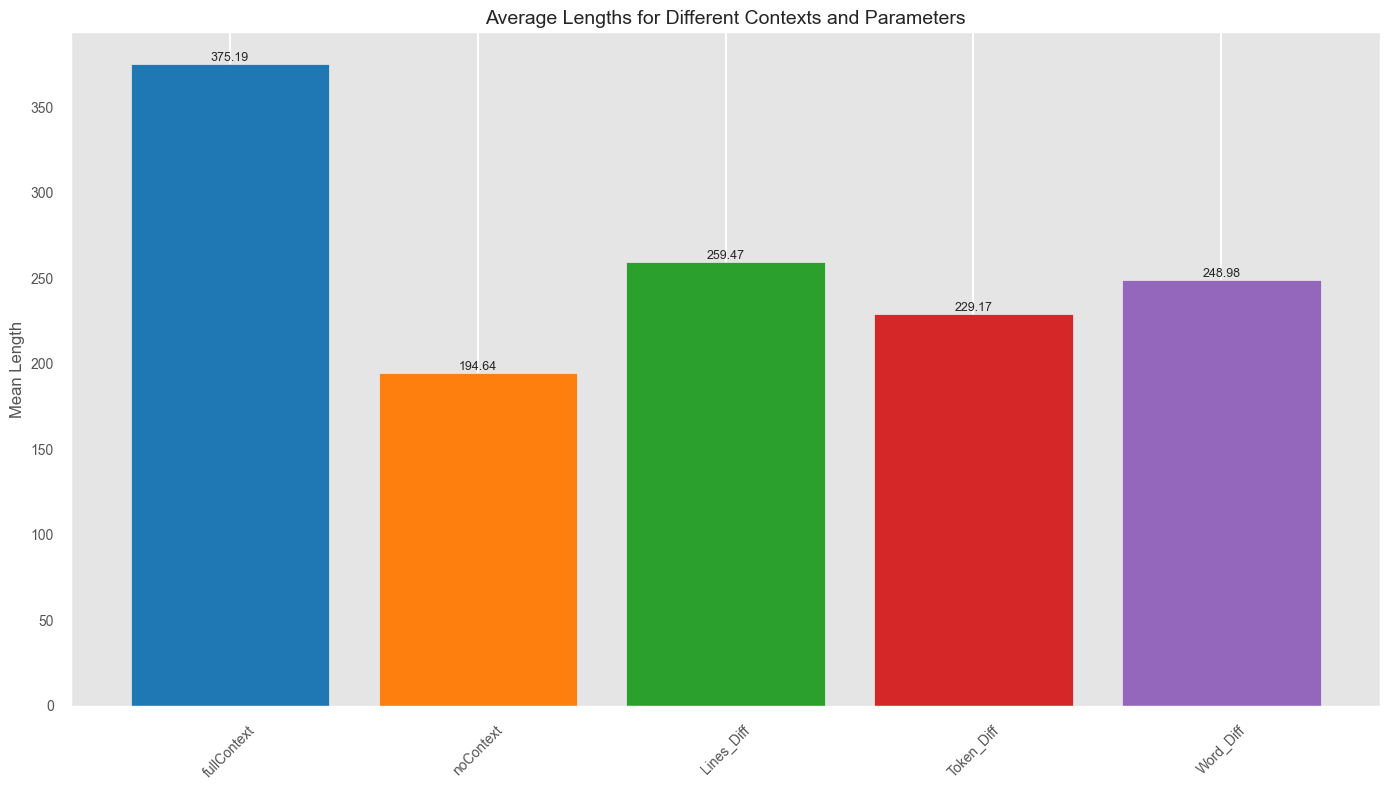

In [190]:
# len_MinTwoFour_Lines_Diff = length_for_filtered_generated_code(MinTwoFour_Lines_Diff)
# len_MinTwoFour_Token_Diff = length_for_filtered_generated_code(MinTwoFour_Token_Diff)
# len_MinTwoFour_Word_Diff = length_for_filtered_generated_code(MinTwoFour_Word_Diff)

plot_histogramFive(flat_length_fullContext,flat_length_noContext,len_MinTwoFour_Lines_Diff, len_MinTwoFour_Token_Diff, len_MinTwoFour_Word_Diff)

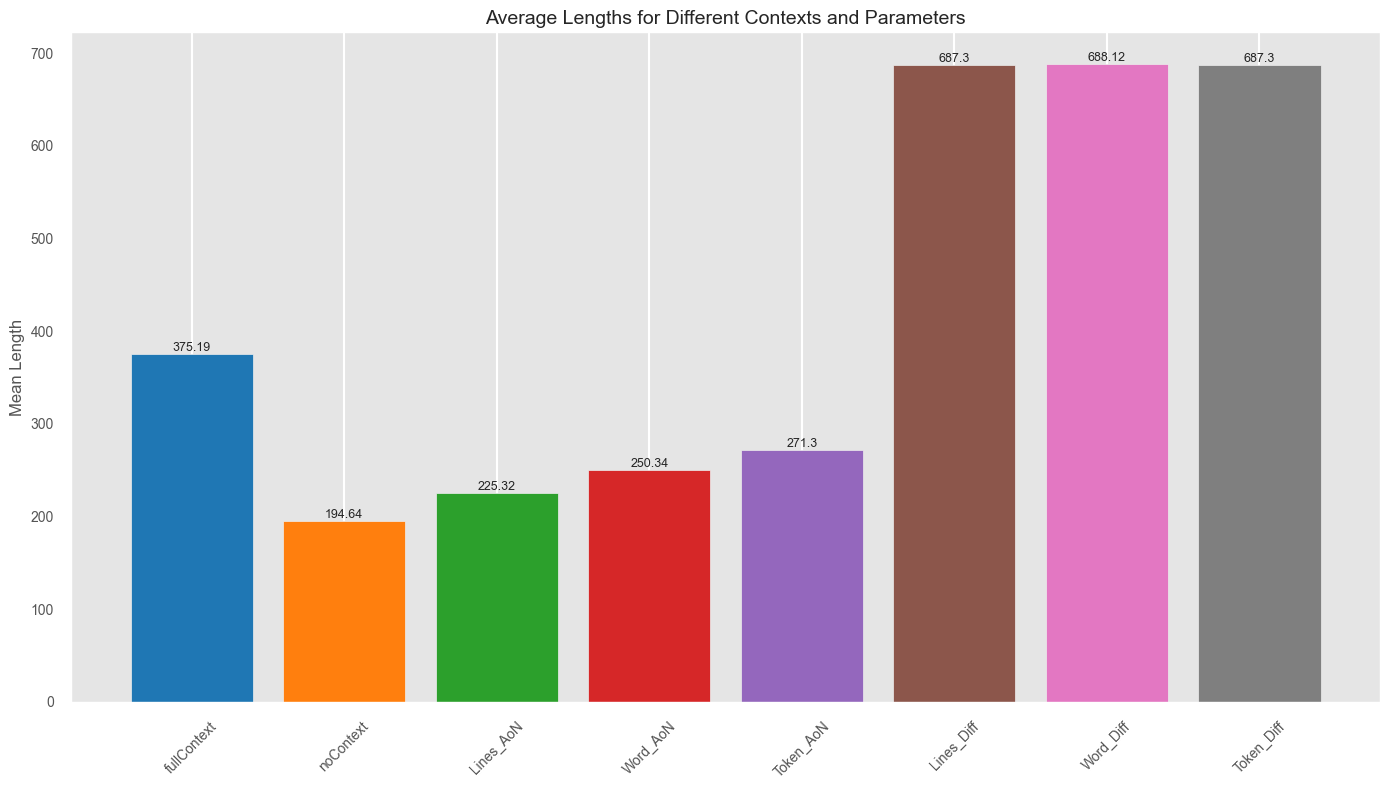

In [182]:

plot_histogram(flat_length_fullContext,flat_length_noContext, len_ZeroTwo_AOR_Line, len_ZeroTwo_AOR_Word, len_ZeroTwo_AOR_Token, len_Token_Diff, len_Word_Diff,len_Token_Diff)

In [100]:
from post_processing import * 

def process_generated_codes_New(data, length_penalty=False):
    """  Apply the post processing to keep only the generated code for both context and without context
    """
    generated_prompts = []
    generated_contexts = []

    for j in range(len(data)):

        generated_prompt = []
        generated_context = []

        if length_penalty:
            codes_context = ast.literal_eval(data.iloc[j]['lenght_penalty_generation'])

            for i in range(len(codes_context)):
                generated_context = keep_only_generated_code_context(codes_context)
            
        else:
            codes_prompt = ast.literal_eval(data.iloc[j]['codes_by_prompts']) 
            codes_context = ast.literal_eval(data.iloc[j]['codes_with_context'])

            for i in range(len(codes_prompt)):
                generated_prompt = keep_only_generated_code_prompts(codes_prompt)
                generated_context = keep_only_generated_code_context(codes_context)

            generated_prompt.append(data.iloc[j]['signature'])
            generated_context.append(data.iloc[j]['signature'])
        generated_prompts.append(generated_prompt)
        generated_contexts.append(generated_context)

    return generated_prompts, generated_contexts

In [105]:
generated_code_prompt, generated_code_context = process_generated_codes_New(data)
lengths_prompt, lengths_context = calculate_lengths(generated_code_prompt, generated_code_context)

flat_length_noContext = [sum(sublist) for sublist in lengths_prompt]
flat_length_fullContext = [sum(sublist) for sublist in lengths_context]

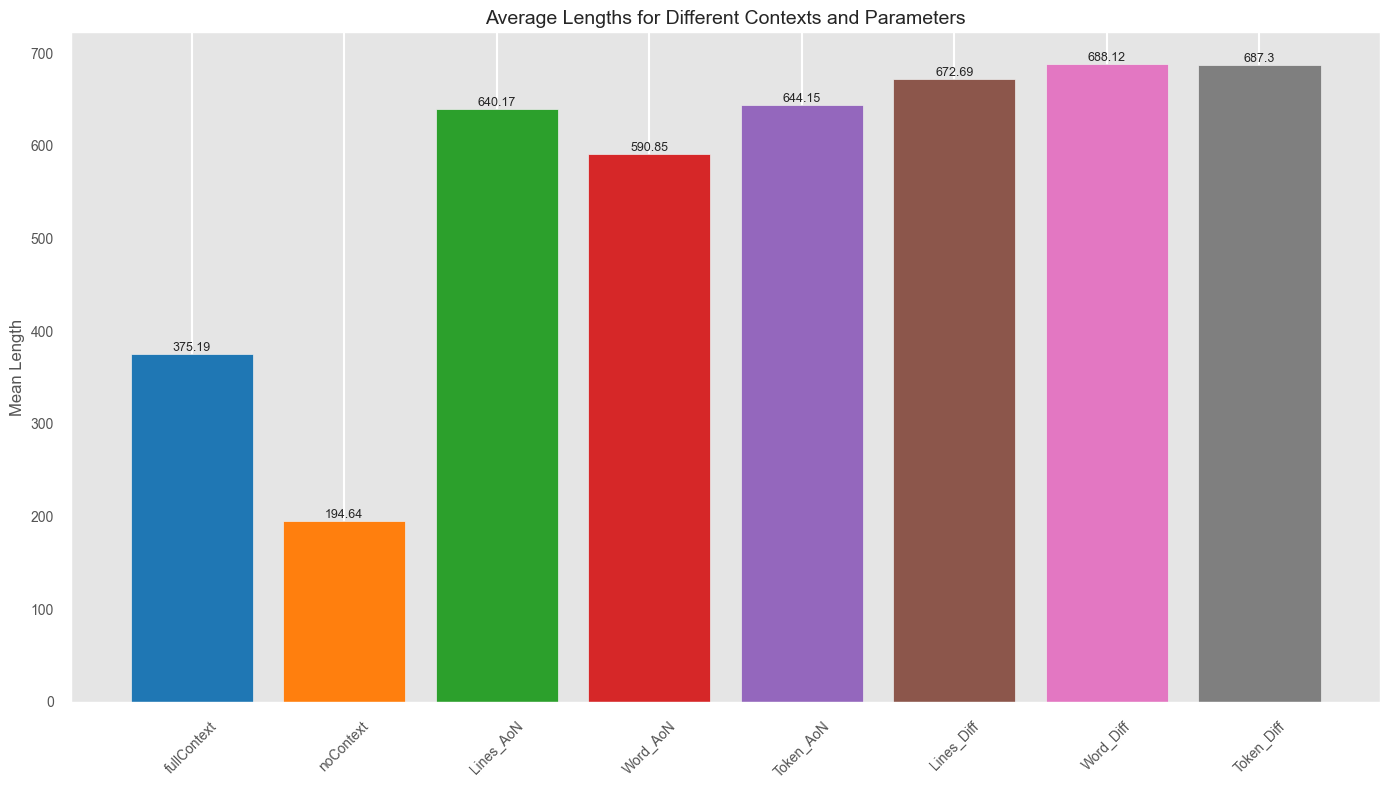

In [106]:

plot_histogram(flat_length_fullContext,flat_length_noContext, len_Lines_AoN, len_Word_AoN, len_Token_AoN, len_Lines_Diff, len_Word_Diff,len_Token_Diff)

<h1>Setting Length Penalty Data for Testing<h1>

In [193]:
import pandas as pd

test = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/5-3/MTBP_Alpha_AOR_EightMinSix_LenToken.csv')

In [195]:
def format_testing_lenght_penalty(data):
    """ Format testing for the Ubuntu."""
    code_to_test = []

    for k in range(len(data)):
        # will take the last one 
        text = ast.literal_eval(data.iloc[k]['lenght_penalty_generation'])[-1]
        processed_text = remove_endoftext(text)
        code_to_test.append(processed_text)
    
    data['code_test'] = code_to_test

    return data

In [ ]:
# AOR
#02
Len_AOR_ZeroDeux_Line = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/02/MTBP_Alpha_AOR_LenLine.csv')
Len_AOR_ZeroDeux_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/02/MTBP_Alpha_AOR_LenToken.csv')
Len_AOR_ZeroDeux_Word = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/02/MTBP_Alpha_AOR_LenWord.csv')
#5-3
Len_AOR_CinqTrois_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/5-3/MTBP_Alpha_AOR_FiveMinThree_LenToken.csv')
#8-6
Len_AOR_HuitSix_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/AOR/8-6/MTBP_Alpha_AOR_MinSixEight_lenToken.csv')

# Diff
#02
Len_Diff_ZeroDeux_Line = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/MTBP_Alpha_Diff_lenLine.csv')
Len_Diff_ZeroDeux_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/MTBP_Alpha_Diff_lenToken.csv')
Len_Diff_ZeroDeux_Word = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/MTBP_Alpha_Diff_lenWord.csv')
#4-2
Len_Diff_QuatreDeux_Line = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/4-2/MTBP_Alpha_Diff_MinTwoFour_lenLine.csv')
Len_Diff_QuatreDeux_Token = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/4-2/MTBP_Alpha_Diff_MinTwoFour_lenToken.csv')
Len_Diff_QuatreDeux_Word = pd.read_csv('data/MTBP/Prompt_vs_context/LenghtPenalty/Diff/4-2/MTBP_Alpha_Diff_MinTwoFour_len.csv')
#8-6
Len_Diff_HuitSix_Token = 